# TODO: add header/description

In [1]:
import tensorflow as tf

GPU_MEM_CONFIG = tf.ConfigProto(gpu_options={'allow_growth': True})
seed_file = 'seeds/3d_gesture.seed.csv'
# BigQuery must be enabled for this project
bq_project = 'patent-landscape-165715'
patent_dataset = 'patents-public-data:patents.publications_latest'
num_anti_seed_patents = 15000


In [2]:
from expansion import PatentLandscapeExpander
from word2vec import Word2Vec

expander = PatentLandscapeExpander(
    seed_file,
    bq_project=bq_project,
    patent_dataset=patent_dataset,
    num_antiseed=num_anti_seed_patents)


word2vec5_9m = Word2Vec('5.9m')
w2v_runtime = word2vec5_9m.restore_runtime()

Will use models/5.9m directory to load/persist model information.
INFO:tensorflow:Restoring parameters from models/5.9m/checkpoints/5.9m_abstracts.ckpt-1325000


In [3]:
training_data_full_df, seed_patents_df, l1_patents_df, l2_patents_df, anti_seed_patents = \
    expander.derive_training_data_from_seeds(seed_file)
training_data_full_df.head()

Querying for all US CPC Counts
Querying for Seed Set CPC Counts
Querying to find total number of US patents
Got 26282 relevant seed refs
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (26282, 1), to patents._l1_tmp
Completed loading temp table.
Shape of L1 expansion: (133137, 3)
Got 522720 relevant L1->L2 refs
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (522720, 1), to patents._l2_tmp
Completed loading temp table.
Shape of L2 expansion: (495565, 3)
Size of union of [Seed, L1, and L2]: 547057
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (547057, 1), to patents.antiseed_tmp
Completed loading temp table.
Loading training data text from (16167, 2) publication numbers
Loading dataframe with cols Index(['publication_number'], dtype='object'), shape (16167, 1), to patents._tmp_training
Completed loading temp table.
Loading patent texts from provided publication numbers.
Merging labels into training data.


,pub_num,publication_number,family_id,priority_date,title_text,abstract_text,claims_text,description_text,refs,cpcs,ExpansionLevel
0,2004116467,US-2004116467-A1,32094123,20021011,Hexahydro-benzimidazolone compounds useful as ...,The present invention is directed to compounds...,We claim: \n \n 1 . A compound ...,[0001] This application claims benefit of p...,"US-3930005-A,US-3930005-A,US-4925854-A,US-4925...","C07D403/10,C07D235/26,C07D403/10,C07D235/26,C0...",AntiSeed
1,7822015,US-7822015-B2,31885289,20040211,Method of operating systems comprising communi...,A method of operatively handling data systems ...,1. A method of operatively handling data syste...,BACKGROUND OF THE INVENTION \n 1. Field of...,"EP-0928548-A1,EP-0928548-A1,EP-0928548-A1,EP-0...","H04Q2213/13349,H04Q3/0062,H04M3/42,H04Q2213/13...",AntiSeed
2,2006228038,US-2006228038-A1,32771501,20030228,Method and system for enhancing portrait image...,A batch processing method for enhancing an app...,1 - 34 . (canceled) \n \n \n 35...,CROSS-REFERENCE TO RELATED APPLICATION \n ...,"US-5430809-A,US-5430809-A,US-5430809-A,US-5430...","G06T11/00,G06T2200/24,G06T5/005,G06T2207/30201...",AntiSeed
3,5839393,US-5839393-A,25237050,19970324,Animal restraint jacket,An animal restraint jacket includes an elongat...,We claim: \n \n 1. An animal restr...,TECHNICAL FIELD \n The present invention r...,"US-1595834-A,US-1595834-A,US-4489676-A,US-4489...","A01K13/006,A61D3/00,A01K13/006,A61D3/00,A01K13...",AntiSeed
4,6568999,US-6568999-B2,23454654,19990805,Method and apparatus for cleaning a surface of...,A method and apparatus for cleaning a surface ...,What is claimed is: \n \n 1. A me...,CROSS-REFERENCE TO RELATED APPLICATION \n ...,"US-5144711-A,US-5144711-A,US-5144711-A,US-5806...","B08B1/04,H01L21/67046,B08B1/00,B08B1/04,H01L21...",AntiSeed


In [4]:
#test_embedding = w2v_runtime.load_embedding('test')
w2v_runtime.find_similar('cinema', 10)

[{'distance': 0.34334943253643091, 'index': 16271, 'word': 'theater'},
 {'distance': 0.42952651805699049, 'index': 22194, 'word': 'exhibition'},
 {'distance': 0.44251179096683857, 'index': 17523, 'word': 'movies'},
 {'distance': 0.47240372507879447, 'index': 18624, 'word': 'studio'},
 {'distance': 0.48089787571297071, 'index': 31126, 'word': 'theatrical'},
 {'distance': 0.48534206041519257, 'index': 33764, 'word': 'theaters'},
 {'distance': 0.49094524468954592, 'index': 11805, 'word': 'projectors'},
 {'distance': 0.49423883364655918, 'index': 30381, 'word': 'cinematographic'},
 {'distance': 0.49438433435760043, 'index': 9310, 'word': 'movie'},
 {'distance': 0.49444645955748223, 'index': 27391, 'word': 'filmed'}]

In [5]:
print(type(w2v_runtime.embedding_weights))
w2v_runtime.embedding_weights.shape

<class 'numpy.ndarray'>


(110240, 300)

In [6]:
training_data_full_df.head()

,pub_num,publication_number,family_id,priority_date,title_text,abstract_text,claims_text,description_text,refs,cpcs,ExpansionLevel
0,2004116467,US-2004116467-A1,32094123,20021011,Hexahydro-benzimidazolone compounds useful as ...,The present invention is directed to compounds...,We claim: \n \n 1 . A compound ...,[0001] This application claims benefit of p...,"US-3930005-A,US-3930005-A,US-4925854-A,US-4925...","C07D403/10,C07D235/26,C07D403/10,C07D235/26,C0...",AntiSeed
1,7822015,US-7822015-B2,31885289,20040211,Method of operating systems comprising communi...,A method of operatively handling data systems ...,1. A method of operatively handling data syste...,BACKGROUND OF THE INVENTION \n 1. Field of...,"EP-0928548-A1,EP-0928548-A1,EP-0928548-A1,EP-0...","H04Q2213/13349,H04Q3/0062,H04M3/42,H04Q2213/13...",AntiSeed
2,2006228038,US-2006228038-A1,32771501,20030228,Method and system for enhancing portrait image...,A batch processing method for enhancing an app...,1 - 34 . (canceled) \n \n \n 35...,CROSS-REFERENCE TO RELATED APPLICATION \n ...,"US-5430809-A,US-5430809-A,US-5430809-A,US-5430...","G06T11/00,G06T2200/24,G06T5/005,G06T2207/30201...",AntiSeed
3,5839393,US-5839393-A,25237050,19970324,Animal restraint jacket,An animal restraint jacket includes an elongat...,We claim: \n \n 1. An animal restr...,TECHNICAL FIELD \n The present invention r...,"US-1595834-A,US-1595834-A,US-4489676-A,US-4489...","A01K13/006,A61D3/00,A01K13/006,A61D3/00,A01K13...",AntiSeed
4,6568999,US-6568999-B2,23454654,19990805,Method and apparatus for cleaning a surface of...,A method and apparatus for cleaning a surface ...,What is claimed is: \n \n 1. A me...,CROSS-REFERENCE TO RELATED APPLICATION \n ...,"US-5144711-A,US-5144711-A,US-5144711-A,US-5806...","B08B1/04,H01L21/67046,B08B1/00,B08B1/04,H01L21...",AntiSeed


In [8]:
training_df = training_data_full_df[
    ['publication_number', 'title_text', 'abstract_text', 'claims_text', 'description_text', 'ExpansionLevel', 'refs', 'cpcs']]

In [9]:
print(training_df[training_df.ExpansionLevel == 'Seed'].count())
print(training_df[training_df.ExpansionLevel == 'AntiSeed'].count())

publication_number    1092
title_text            1092
abstract_text         1092
claims_text           1092
description_text      1092
ExpansionLevel        1092
refs                  1092
cpcs                  1092
dtype: int64
publication_number    9629
title_text            9629
abstract_text         9629
claims_text           9629
description_text      9629
ExpansionLevel        9629
refs                  9629
cpcs                  9629
dtype: int64


In [193]:
from keras.preprocessing import text

import tokenizer
tokenizer = tokenizer.TextTokenizer()
kTokenizer = text.Tokenizer(
    num_words=50000,
    split=",",
    # filter should be same as default, minus the '-'
    filters='!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n',
    lower=False)

class TrainingData:
    training_df = None
    series_text_to_embed = None
    prepped_embedding_train = None
    prepped_refs = None
    prepped_labels = None
    w2v_runtime = None
    ref_to_id = None
    id_to_ref = None

def label_text_to_id(label_name):
    if label_name == 'antiseed':
        return 1
    else:
        return 0

def label_id_to_text(label_idx):
    if label_idx == 1:
        return 'antiseed'
    else:
        return 'seed'

def tensor_label_to_text(tensor_text):
    # if element 0 is '1', it means that this is the
    # zeroth label index
    if tensor_text[0] == 1.0:
        return label_id_to_text(0)
    return label_id_to_text(1)

def prediction_to_label(predict_tensor):
    return label_id_to_text(prediction_to_idx(predict_tensor))

def prediction_to_idx(predict_tensor):
    # if element 0 is greater than element 1, it's the label
    if predict_tensor[0] > predict_tensor[1]:
        return 0
    return 1

def to_text(integerized):
    words = []
    for word_int in integerized:
        words.append(w2v_runtime.index_to_word[word_int])
    return ' '.join(words)

def show_details(training_data_series, idx):
    print('\nOriginal: {}\nTokenized: {}\nIntegerized: {}\nLabelIntegerized: {}'.format(
        training_data_series[idx],
        to_text(prepped_train[idx]),
        prepped_train[idx],
        prepped_labels[idx]))

def prep_series_for_training(w2v_runtime, raw_series_text, labels_series):

    tokenized_text = tokenizer.tokenize_series(raw_series_text)
    word_to_index_dict = w2v_runtime.word_to_index
    tokenized_indexed_titles = []
    labels_indexed = []

    for idx in range(0, len(tokenized_text)):
        title = tokenized_text[idx]
        label = labels_series[idx]
        title_word_indexes = []
        for word in title:
            if word in word_to_index_dict:
                word_idx = word_to_index_dict[word]
            else:
                word_idx = word_to_index_dict['UNK']
            # this skips 'the' so it can be used for dynamic rnn
            if word_idx > 0:
                title_word_indexes.append(word_idx)

        tokenized_indexed_titles.append(title_word_indexes)
        tokenized_label = tokenizer.tokenize(label)[0]
        label_idx = label_text_to_id(tokenized_label)
        labels_indexed.append(label_idx)

    return tokenized_indexed_titles, labels_indexed

from collections import Counter, OrderedDict

def tokenize_refs(refs_series, vocab_size=1000):
    refs_counter = Counter()
    for idx in range(0, len(refs_series)):
        refs = refs_series[idx]
        for ref in refs.split(','):
            if ref.strip() is not '':
                refs_counter[ref.strip()] += 1

    if len(refs_counter) >= vocab_size:
        print('reducing ref count from {} to top {} refs'.format(len(refs_counter), vocab_size))
        refs_counter = OrderedDict(refs_counter.most_common(vocab_size - 1))

    refs_counter['UNK'] = 1

    sorted_ref_vocab = sorted(refs_counter, key=refs_counter.get, reverse=True)
    id_to_ref = {ii: ref for ii, ref in enumerate(sorted_ref_vocab)}
    ref_to_id = {ref: ii for ii, ref in id_to_ref.items()}

    tokenized_refs = []
    for idx in range(0, len(refs_series)):
        refs = refs_series[idx]
        refs_for_patent = []
        for ref in refs.split(','):
            if ref.strip() is not '' and ref in ref_to_id:
                refs_for_patent.append(ref_to_id[ref])

        tokenized_refs.append(refs_for_patent)

    return tokenized_refs, id_to_ref, ref_to_id
    # TODO: reconstruct series with ids instead of text of refs

    #for idx in range(0, len(refs_series)):
    #    for ref in refs.split(','):

def ref_ids_to_text(training_data, ref_onehot):
    refs = []
    for idx in range(1, len(ref_onehot)+1):
        if ref_onehot[idx-1] == 1.0:
            refs.append(kTokenizer.index_word[idx])
    #for ref_id in ref_ids:
    #    if ref_id in training_data.id_to_ref:
    #        refs.append(training_data.id_to_ref[ref_id])
    return refs


In [194]:
td = TrainingData()
td.kTokenizer = kTokenizer
td.w2v_runtime = w2v_runtime
td.training_df = training_df
td.series_text_to_embed = training_df.abstract_text

td.prepped_embedding_train, td.prepped_labels = \
    prep_series_for_training(td.w2v_runtime, td.series_text_to_embed, training_df.ExpansionLevel)

kTokenizer.fit_on_texts(td.training_df.refs)
kTokenizer.index_word = {idx: ref for ref, idx in kTokenizer.word_index.items()}
td.refs_one_hot = kTokenizer.texts_to_matrix(td.training_df.refs)


In [192]:
#print(len(td.kTokenizer.word_index))
#print(td.refs_one_hot.shape)
#td.kTokenizer.index_word

179207
(10721, 50000)


In [195]:
#training_data_series = training_df.abstract_text

#prepped_train, prepped_labels = \
#    prep_series_for_training(w2v_runtime, training_data_series, training_df.ExpansionLevel)

print('Num documents: {}, num tokenized docs: {}, num labels: {}'.format(
    training_df.shape, len(td.prepped_embedding_train), len(td.prepped_labels)))


Num documents: (10721, 8), num tokenized docs: 10721, num labels: 10721


In [196]:
show_details(td.series_text_to_embed, 0)
#show_details(training_data_series, 4)
#show_details(training_data_series, 400)
#show_details(training_data_series, 16)


Original: The present invention is directed to compounds having the formula (I):  
                         
 
     useful in treating inflammatory and immune diseases, in which K is O or S; Q is —C(═O)— or optionally substituted C 1-4 alkylene; Ar is optionally-substituted aryl or heteroaryl; J 1 , J 2 , J 3 , and Y are selected so that ring A is a five-to-six membered optionally-substituted cycloalkenyl or heterocyclo ring having 0 to 2 nitrogen heteroatoms; Z is N or C(R 9 ); and R 1 , R 2 , R 3  and R 9  are as defined in the specification.
Tokenized: present invention is directed to compounds having formula i useful in treating inflammatory and immune diseases in which k is o or s q is UNK UNK UNK or optionally substituted c _NUMBER_ _NUMBER_ alkylene ar is optionally substituted aryl or heteroaryl j _NUMBER_ j _NUMBER_ j _NUMBER_ and y are selected so that ring a is a five to six membered optionally substituted cycloalkenyl or heterocyclo ring having _NUMBER_ to _NUMBER_ nitroge

In [198]:
import random
RAND_SEED=314159

def randomize_training(td, percent_train):

    training_data_to_shuffle = list(
        zip(td.prepped_embedding_train, td.refs_one_hot, td.prepped_labels))
    random.seed(RAND_SEED)
    random.shuffle(training_data_to_shuffle)
    train_embed_arr, refs_one_hot, label_arr = zip(*training_data_to_shuffle)

    train_idx = int(len(train_embed_arr) * percent_train)

    td.trainEmbedX = train_embed_arr[:train_idx]
    td.trainRefsOneHotX = refs_one_hot[:train_idx]
    td.testEmbedX = train_embed_arr[train_idx:]
    td.testRefsOneHotX = refs_one_hot[train_idx:]

    td.trainY = label_arr[:train_idx]
    td.testY = label_arr[train_idx:]

    return td

td = randomize_training(td, 0.8)


In [199]:
print_idx = 0
for row in td.trainY:
    if td.trainY[print_idx] == 0:
        break
    else:
        print_idx += 1

print('Using index {}.'.format(print_idx))
print(td.trainEmbedX[print_idx])
print(to_text(td.trainEmbedX[print_idx]))
print(td.trainRefsOneHotX[print_idx])
print(ref_ids_to_text(td, td.refs_one_hot[30]))
print(td.trainY[print_idx])

Using index 29.
[1, 375, 378, 9, 4908, 10267, 69, 1, 375, 778, 9, 2595, 8804, 2, 1, 124, 75, 778, 7, 140, 269, 2, 1316, 6, 1295, 83, 8, 59, 378, 166, 10, 375, 778, 9, 365, 1, 47, 2, 777, 10267, 15, 8804, 2178, 12, 375, 778, 3, 1, 276, 166, 10, 59, 378, 79, 276, 38, 20, 6, 1, 14195, 266, 11, 8, 327, 266, 3, 79, 276, 4097, 15, 14195, 266, 4, 327, 266, 52, 59, 378, 1228, 1, 7349, 2, 56, 1858, 75, 2178, 8804, 56, 1858, 65, 262, 1, 405, 17505, 3, 1087, 8, 303, 777, 3, 79, 276, 1481, 1, 2252, 849, 875, 4, 8, 286, 25, 91, 17, 777, 10267, 493, 12, 59, 378, 52, 276, 5, 6, 327, 266, 1, 30, 3, 1, 225, 2359, 165, 272, 13, 61, 309, 3, 4229]
a video processor for recognizing gestures including a video camera for capturing photographs of a region within camera _NUMBER_ s field of view in real time an image processor coupled with video camera for detecting a plurality of hand gestures from photographs captured by video camera and a controller coupled with image processor wherein controller can be in a

# Train LSTM Using Embeddings

In [202]:
import numpy as np

td.trainEmbedX, td.trainRefsOneHotX, td.testEmbedX, td.testRefsOneHotX = \
    np.array(td.trainEmbedX), \
    np.array(td.trainRefsOneHotX), \
    np.array(td.testEmbedX), \
    np.array(td.testRefsOneHotX)

td.trainY, td.testY = np.array(td.trainY), np.array(td.testY)

In [203]:
print('training embedding data shape: {}, train labels shape: {}'.format(
    td.trainEmbedX.shape, td.trainY.shape))
print('test data shape: {}, test labels shape: {}'.format(td.testEmbedX.shape, td.testY.shape))

doc_lengths = list(map(len, td.trainEmbedX))
median_doc_length = int(np.median(doc_lengths))
max_doc_length = np.max(doc_lengths)
print('median doc length: {}'.format(median_doc_length))
print('mean doc length: {}'.format(np.mean(doc_lengths)))
print('max doc length: {}'.format(max_doc_length))


training embedding data shape: (8576,), train labels shape: (8576,)
test data shape: (2145,), test labels shape: (2145,)
median doc length: 103
mean doc length: 104.05771921641791
max doc length: 384


In [204]:
#tokenizer.tokenize(text=)
#training_df.refs.head()
len(td.prepped_embedding_train[0])


96

# Keras LSTM Model

In [218]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, BatchNormalization, ELU
from keras.layers import LSTM, Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.layers.core import Dropout
from keras_metrics import precision, recall, f1score
#from keras.datasets import imdb

batch_size = 32

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_size = 128

sequence_len = max_doc_length


In [219]:
td.padded_train_embed_x = sequence.pad_sequences(
    td.trainEmbedX, maxlen=sequence_len, padding='pre', truncating='post')
td.padded_test_embed_x = sequence.pad_sequences(
    td.testEmbedX, maxlen=sequence_len, padding='pre', truncating='post')


In [235]:
print('Build model...')

wide = Sequential()
wide.add(Dense(256, input_dim=td.trainRefsOneHotX.shape[1], name='refs'))
wide.add(Dense(64, input_dim=256))

deep = Sequential()

embedding_layer = Embedding(w2v_runtime.embedding_weights.shape[0],
                            w2v_runtime.embedding_weights.shape[1],
                            weights=[w2v_runtime.embedding_weights],
                            #input_length=sequence_len,
                            trainable=False,
                            name='embed')
deep.add(embedding_layer)
'''
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
'''
deep.add(LSTM(
    lstm_size,
    dropout=0.2,
    recurrent_dropout=0.2,
    return_sequences=False,
    name='LSTM_1'))
#model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=False, name='LSTM_2'))
deep.add(Dense(300, activation=None))
deep.add(Dropout(0.2))
deep.add(BatchNormalization())
deep.add(ELU())

model = Sequential()
#wide_input = concatenate(inputs=[wide, deep])
#model.add(concatenate([wide, deep], axis=0))
model.add(Merge([wide, deep], mode='concat', concat_axis=1))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', precision, recall, f1score])


print('Train...')
#for seq, label in zip(trainX, trainY):
#    print('fitting\n seq: {} \n label: {}\n'.format(seq, label))
#    model.train_on_batch(np.array([seq]), [label])

model.fit(x={'refs_input': td.trainRefsOneHotX, 'embed_input': td.padded_train_embed_x},
          y=td.trainY,
          batch_size=batch_size,
          epochs=5,
          validation_data=(
              {'refs_input': td.testRefsOneHotX, 'embed_input': td.padded_test_embed_x},
              td.testY))


Build model...


/usr/local/google/home/feltenberger/anaconda3/envs/pl35/lib/python3.5/site-packages/ipykernel/__main__.py:39: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Train...
Train on 8576 samples, validate on 2145 samples
Epoch 1/5
8576/8576 [==============================] - 137s - loss: 0.0857 - acc: 0.9677 - precision: 0.9854 - recall: 0.9776 - fmeasure: 0.9799 - val_loss: 0.0314 - val_acc: 0.9911 - val_precision: 0.9924 - val_recall: 0.9979 - val_fmeasure: 0.9951
Epoch 2/5
8576/8576 [==============================] - 137s - loss: 0.0112 - acc: 0.9981 - precision: 0.9982 - recall: 0.9998 - fmeasure: 0.9989 - val_loss: 0.0281 - val_acc: 0.9925 - val_precision: 0.9940 - val_recall: 0.9979 - val_fmeasure: 0.9959
Epoch 3/5
8576/8576 [==============================] - 132s - loss: 0.0064 - acc: 0.9991 - precision: 0.9992 - recall: 0.9997 - fmeasure: 0.9995 - val_loss: 0.0269 - val_acc: 0.9935 - val_precision: 0.9955 - val_recall: 0.9974 - val_fmeasure: 0.9964
Epoch 4/5
8576/8576 [==============================] - 136s - loss: 0.0056 - acc: 0.9994 - precision: 0.9996 - recall: 0.9997 - fmeasure: 0.9997 - val_loss: 0.0320 - val_acc: 0.9939 - val_preci

In [236]:
score, acc, p, r, f1 = model.evaluate(
    x={'refs_input': td.testRefsOneHotX, 'embed_input': td.padded_test_embed_x},
    y=test_y,
    batch_size=batch_size)

print('')
print('Test score: {:.4f}'.format(score))
print('Test accuracy: {:.4f}'.format(acc))
print('Test p/r (f1): {:.2f}/{:.2f} ({:.2f})'.format(p, r, f1))


2145/2145 [==============================] - 8s     

Test score: 0.0332
Test accuracy: 0.9935
Test p/r (f1): 0.99/1.00 (1.00)


In [30]:
trainX

array([ [8, 48, 5, 90, 14, 39, 771, 1, 2506, 149, 58, 1, 18, 3471, 2191, 4, 16472, 1282, 8, 384, 2, 4482, 2, 58, 17, 2506, 3, 1, 22, 3471, 2191, 4, 3934, 1282, 8, 384, 2, 4482, 2, 58, 17, 2506, 6, 21, 288, 48, 39, 20, 82, 23, 1, 115, 9653, 240, 9, 1, 392, 58, 103],
       [81, 45, 199, 4, 980, 470, 1475, 91, 485, 1977, 3, 1, 30, 2, 597, 197, 12, 1, 15956, 171, 401, 735, 4, 1479, 2, 387, 8, 315, 1088, 910, 2, 387, 5, 402, 1, 658, 11, 39132, 1115, 575, 2, 7, 7, 110239, 596, 5, 55, 33, 76, 3, 178, 40, 2, 387, 6, 14, 1115, 575, 576, 201, 5, 2494, 12, 53, 2, 178, 40],
       [8, 1768, 9, 1206, 1, 144, 172, 24, 1, 76, 3, 1768, 753, 17, 76, 151, 4, 361, 882, 172, 753, 17, 1, 144, 172, 28, 1768, 126, 24, 1, 4241, 242, 40, 55, 23, 1, 242, 310, 73, 6, 582, 24573, 242, 40, 24, 1, 850, 9, 653, 172, 126, 3, 1, 310, 790, 35, 9, 2954, 367, 850, 1, 30, 9, 1937, 1768, 24, 467, 2, 2982, 76, 133, 1, 242, 40, 17, 1, 271, 35, 2, 76, 3, 757, 16, 31, 602, 2, 271, 35, 271, 35, 38, 771, 1, 1609, 363, 11, 4044,

array([1, 1, 1, ..., 1, 1, 1])

## TensorFlow LSTM Graph

In [30]:
lstm_size = 256
lstm_layers = 1
batch_size = 128
learning_rate = 0.001
vocab_size = w2v_runtime.embedding_weights.shape[0]
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = w2v_runtime.embedding_weights.shape[1]

epochs = 10


In [31]:
# Create the graph object
graph = tf.Graph()

with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    embedding = tf.get_variable(
        name="embedding",
        shape=w2v_runtime.embedding_weights.shape,
        initializer=tf.constant_initializer(w2v_runtime.embedding_weights),
        trainable=False)
    embed = tf.nn.embedding_lookup(embedding, inputs_)

    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)

    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

    outputs, final_state = tf.nn.dynamic_rnn(cell, embed,
                                             initial_state=initial_state)

    predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.sigmoid)
    cost = tf.losses.mean_squared_error(labels_, predictions)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


In [32]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [33]:

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph, config=GPU_MEM_CONFIG) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {inputs_: x,
                    labels_: y[:, None],
                    keep_prob: 0.5,
                    initial_state: state}
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            
            if iteration%5==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))

            if iteration%25==0:
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(test_x, test_y, batch_size):
                    feed = {inputs_: x,
                            labels_: y[:, None],
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1
    saver.save(sess, "checkpoints/sentiment.ckpt")


Epoch: 0/10 Iteration: 5 Train loss: 0.134
Epoch: 0/10 Iteration: 10 Train loss: 0.102
Epoch: 0/10 Iteration: 15 Train loss: 0.131
Epoch: 0/10 Iteration: 20 Train loss: 0.086
Epoch: 0/10 Iteration: 25 Train loss: 0.121
Val acc: 0.884
Epoch: 0/10 Iteration: 30 Train loss: 0.083
Epoch: 0/10 Iteration: 35 Train loss: 0.064
Epoch: 0/10 Iteration: 40 Train loss: 0.211
Epoch: 0/10 Iteration: 45 Train loss: 0.101
Epoch: 0/10 Iteration: 50 Train loss: 0.065
Val acc: 0.910
Epoch: 0/10 Iteration: 55 Train loss: 0.092
Epoch: 0/10 Iteration: 60 Train loss: 0.051
Epoch: 0/10 Iteration: 65 Train loss: 0.053
Epoch: 0/10 Iteration: 70 Train loss: 0.037
Epoch: 0/10 Iteration: 75 Train loss: 0.038
Val acc: 0.933
Epoch: 1/10 Iteration: 80 Train loss: 0.039
Epoch: 1/10 Iteration: 85 Train loss: 0.079
Epoch: 1/10 Iteration: 90 Train loss: 0.056
Epoch: 1/10 Iteration: 95 Train loss: 0.033
Epoch: 1/10 Iteration: 100 Train loss: 0.042
Val acc: 0.949
Epoch: 1/10 Iteration: 105 Train loss: 0.057
Epoch: 1/10 Ite

In [39]:

test_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(l1_x, l1_y, batch_size), 1): #can also use test_x, test_y
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints/sentiment.ckpt
Test accuracy: 0.335


# Inference! (Ignore everything below here for now)

In [21]:
import importlib

import expansion

importlib.reload(expansion)
expander = expansion.PatentLandscapeExpander(
    seed_file,
    bq_project=bq_project,
    patent_dataset=patent_dataset,
    num_antiseed=num_anti_seed_patents)


In [22]:

#training_df[training_df.abstract_text.str.contains('learn') & training_df.abstract_text.str.contains('machine')]

#training_df[training_df.abstract_text.str.contains('machine')]
l1_texts = expander.load_training_data_from_pubs(l1_patents_df[['publication_number']])
l1_texts['label'] = 'Seed'
l1_texts.head()


Loading dataframe with cols Index(['publication_number'], dtype='object'), shape (133137, 1), to patents._tmp_training
Completed loading temp table.
Loading patent texts from provided publication numbers.


GenericGBQException: Reason: apiLimitExceeded, Message: API limit exceeded: Unable to return a row that exceeds the API limits. To retrieve the row, export the table.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def binary_prediction_idx(score):
    if score < .5:
        return 0
    return 1

def predictions_for_report(patent_model, validX, validY):
    target_names = ['seed', 'antiseed']

    prediction_scores = patent_model.predict(validX)
    predictions = []
    actual_y = []

    for idx in range(0, len(prediction_scores)):
        prediction = prediction_scores[idx]
        actual = validY[idx]
        predictions.append(binary_prediction_idx(prediction[0]))
        actual_y.append(actual)

    return predictions, actual_y, target_names


In [41]:
import pandas as pd
l1_texts_subset = l1_texts.abstract_text[:10000]
l1_texts_subset.reset_index(drop=True, inplace=True)
l1_texts_subset.loc[len(l1_texts_subset)-1] = 'this abstract is about something entirely boring'

l1_labels_subset = l1_texts.label[:10000]
l1_labels_subset.reset_index(drop=True, inplace=True)
l1_labels_subset.loc[len(l1_texts_subset)-1] = 'AntiSeed'

print('Prepping series (tokenization etc.) for training.')
l1_x, l1_y = prep_series_for_training(w2v_runtime, l1_texts_subset, l1_labels_subset)
l1_x = np.array(l1_x)
l1_y = np.array(l1_y)

print('Padding sequences.')
# Convert text idx into padded sequences
l1_x = sequence.pad_sequences(
        l1_x, maxlen=sequence_len, padding='pre', truncating='post')
# Converting labels to binary vectors
#l1_y = to_categorical(l1_y, nb_classes=2)

print('Making predictions')
l1_preds, actual_l1_y, target_names = predictions_for_report(model, l1_x, l1_y)

cr = classification_report(l1_preds, actual_l1_y, target_names=target_names)
cm = confusion_matrix(l1_preds, actual_l1_y)
print(cr)
print(cm)
#l1_texts_subset

Prepping series (tokenization etc.) for training.
Padding sequences.
Making predictions
             precision    recall  f1-score   support

       seed       0.31      1.00      0.47      3070
   antiseed       1.00      0.00      0.00      6930

avg / total       0.79      0.31      0.14     10000

[[3070    0]
 [6929    1]]


In [120]:
#print(l1_preds)
l1_preds_df = pd.DataFrame(l1_preds, columns=['PredictionIdx'])
l1_preds_df['Prediction'] = l1_preds_df.PredictionIdx.apply(label_id_to_text)
l1_preds_df

,PredictionIdx,Prediction
0,1,antiseed
1,1,antiseed
2,1,antiseed
3,0,seed
4,1,antiseed
5,1,antiseed
6,1,antiseed
7,1,antiseed
8,1,antiseed
9,1,antiseed


In [114]:
l1_texts_subset[1]

'The present invention relates to a method for detecting fetal Down syndrome (Trisomy 21), trisomy 13, trisomy 18 and other chromosomal anomalies during prenatal screening by analyzing a dried blood sample from a pregnant woman. More particularly the present invention relates to a method for improving detection efficiency in screening for the anomalies by measuring the amount of the free beta human chorionic gonadotropin (HCG) and nicked or fragmented or aberrant forms of free beta (HCG), all of which are referenced throughout this application as free beta (HCG) in dried blood samples from pregnant women.'

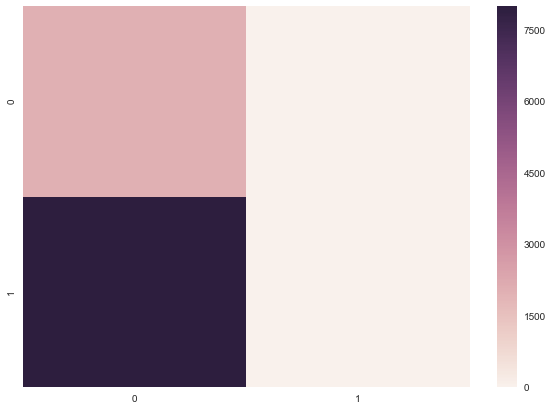

In [93]:
%matplotlib inline

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm_df = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sn.heatmap(cm_df)

In [23]:
import pandas as pd

def make_prediction(patent_model, text, expected_label, max_seq_len, mask_idx=0):
    inf_series = pd.Series([text])
    lab_series = pd.Series([label])

    prepped_train, prepped_labels = \
        prep_series_for_training(
            w2v_runtime=w2v_runtime,
            labels_series=lab_series,
            raw_series_text=inf_series)

    # make sure we have the correct sequence length
    #infX = pad_sequences(prepped_train, maxlen=max_seq_len, value=mask_idx)
    infX = sequence.pad_sequences(
        prepped_train, maxlen=sequence_len, padding='pre', truncating='post')
    #prepped_train = np.array(prepped_train)

    # actually make prediction
    prediction = patent_model.predict(infX)

    return prediction


In [34]:
model.save(filepath='checkpoints/keras_model.ckpt')

In [33]:
text = 'a really boring title that is super long and has nothing to do with the topic that im interested in. but has a bit of stuff about artificial neural networks and things i haven\'t heard of?'
text = 'three dimensional mapping'
#text = l1_texts_subset[10]
label = 'Seed'
prediction = make_prediction(model, text, expected_label=label, max_seq_len=sequence_len)
print('Text: {}'.format(text))
#print('Tokenized/Integerized: {}'.format(prepped_train))
#print('Padded: {}'.format(infX))
print('Prediction: {}'.format(prediction))
print('Predicted Label: {}, Actual Label: {}'.format(label_id_to_text(binary_prediction_idx(prediction)), label))


Text: three dimensional mapping
Prediction: [[ 0.98487407]]
Predicted Label: antiseed, Actual Label: Seed


In [302]:
#oldidx = print_idx
#print_idx = oldidx
#print(model.predict([trainX[print_idx]]))
#tensor_label_to_text(trainY[print_idx])